In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import talib 
from empyrical import max_drawdown

In [2]:
data = pd.read_csv('data.csv')

In [3]:
def macd(data):
    data['MACD'] = data['close'].ewm(span = 12,adjust=False).mean() - data['close'].ewm(span=28,adjust=False).mean()
    data['Signal_MACD'] = data['MACD'].ewm(span = 7 ,adjust = False).mean()
    return data
data = macd(data)

In [4]:
data ['IBS'] = (data['close'] - data['low']) /(data['high'] - data['low'])
data['weight_avg'] = data['IBS'].ewm(span=5,adjust=False).mean() 

In [5]:
data

,datetime,high,low,close,open,volume,MACD,Signal_MACD,IBS,weight_avg
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076,0.000000,0.000000,0.360301,0.360301
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340,122.652520,30.663130,0.908601,0.543068
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601,232.403789,81.098295,0.453324,0.513153
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561,321.580106,141.218748,0.655643,0.560650
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333,538.490042,240.536571,0.785901,0.635734
...,...,...,...,...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870,-2392.123514,-1847.617011,0.102454,0.236712
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660,-2498.736854,-2010.396972,0.812916,0.428780
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360,-2586.976469,-2154.541846,0.623133,0.493564
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280,-2531.395089,-2248.755157,0.822257,0.603129


In [6]:
data['signals'] = 0
for i in range(7,len(data)):
    if(data['weight_avg'][i-1]>0.7 and data.MACD[i] > data.Signal_MACD[i] ):
        data.signals[i] = 1
    elif(data['weight_avg'][i-1]<0.3 and data.MACD[i] < data.Signal_MACD[i]):
        data.signals[i] = -1

C:\Users\Rachit\AppData\Local\Temp\ipykernel_19516\2494417351.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.signals[i] = -1
C:\Users\Rachit\AppData\Local\Temp\ipykernel_19516\2494417351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.signals[i] = 1


In [7]:
data.to_csv('IBS.csv')

In [8]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.0675 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 1000 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe() , self.create_every_day_dataframe()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        cumulative_excess_return = df['excess_return'].sum()
        negative_returns = [r for r in df['excess_return'] if r < 0]
        cumulative_volatility = df['daily_return'].std()*math.sqrt(365)
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative

        
    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = self.datetime
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Maximum drawdown:',np.min(self.drawdown))
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))
        print('Number of times take profit met:',len(self.take_profit_count))
        print('Sharpe ratio:',self.sharpe_ratio)
        print('Sortino ratio:',self.sortino_ratio)

Number of closed trade: 34
Winning trades: 25
Losing trades: 9
Benchmark returns: 2248.9531785306435
Win rate: 73.52941176470588
Maximum drawdown: -23.713521845586193
Largest win: 58.17755840315088
Average win: 17.09831968989507
Largest loss: -9.32131857038031
Average loss: -5.47238259411261
Maximum holding time: 49
Average holding period: 13.882352941176471
Gross Profit: 24061.66165869946
Net Profit: 23684.007015386574
Returns: 2368.4007015386574 %
Number of times stop loss met: 33
Number of times take profit met: 0
Sharpe ratio: 1.8852987315908274
Sortino ratio: 1.4828063676709293


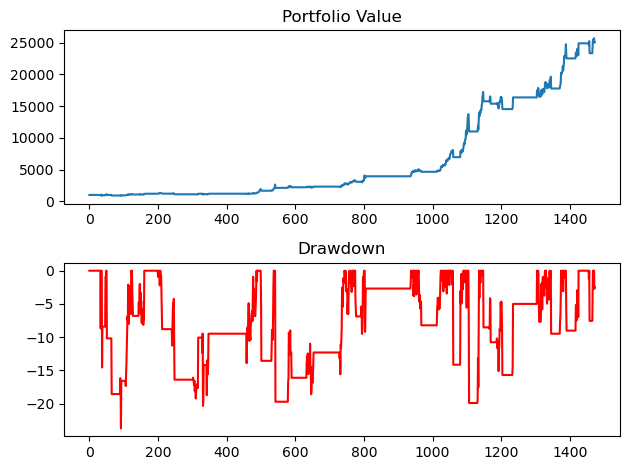

In [9]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise, every_day = Testing_signals.compounding()

In [10]:
trade_wise

,entry,exit,duration,trade type,returns
0,32,34,2,short,3.455980
1,36,38,2,short,-8.412384
2,46,51,5,long,5.591151
3,64,65,1,long,-9.321319
4,89,93,4,short,2.435550
5,105,127,22,long,14.925187
6,143,160,17,short,10.892804
7,198,212,14,long,1.514952
8,240,248,8,long,-8.332370
9,301,317,16,short,7.569696


In [11]:
class TradingStrategy:

    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally
        self.trade_returns=[]
        self.portfolio_value = [] # this is the temporary portfolio value, which will store for a particular trade, then reset
        self.trade_wise_holding = [] # this represents the holding for each trade
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (temporary variable)

        self.trade_wise_final_portfolio = [] # this represents final portfolio value for each trade

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.07 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 100 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each trade
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        # self.transaction_percentage = 0.0015
        self.transaction_cost_per_trade = []
        self.transaction_cost_in_one_trade = 1.5

        self.risk_free_rate = 0.05 # you can change it

        self.drawdown = []
        self.dip = []
        self.trade_wise_returns = []
        self.PL_in_dollars = []

    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        trade_max_drawdown = np.min(drawdown)
        return trade_max_drawdown

    def calculate_dip(self):
        data = self.portfolio_value
        min_portfolio_value = np.min(data)
        dip = (1000 - min_portfolio_value) / 10
        return dip
    
    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding) # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding)
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
    
    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
    
    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)
    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def static(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.gross_profit_per_trade = np.array(self.trade_wise_final_portfolio) - 1000
        self.trade_returns= np.array(self.trade_wise_final_portfolio)/10 - 100
        self.net_profit_per_trade = np.array(self.gross_profit_per_trade) - (self.transaction_cost_in_one_trade)

        self.profitable_trade = []
        self.loss_trade = []
        for i in range(len(self.entry)):
            if self.net_profit_per_trade[i] >= 0:
                self.profitable_trade.append(self.net_profit_per_trade[i])
            else:
                self.loss_trade.append(self.net_profit_per_trade[i])

        self.returns = np.sum(self.net_profit_per_trade) / 10

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe()

        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''


    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit
    
    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['quantity'] = self.trade_wise_holding
        trade_wise['trade type'] = self.trade_type
        trade_wise['final portfolio value'] = self.trade_wise_final_portfolio
        trade_wise['returns']=self.trade_returns
        trade_wise['drawdown'] = self.drawdown
        trade_wise['dip'] = self.dip
        return trade_wise
    
    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.profitable_trade))
        print('Losing trades:',len(self.loss_trade))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.profitable_trade)/len(self.entry))*100)
        print('Gross profit:',np.sum(self.gross_profit_per_trade))
        print('Net profit:',np.sum(self.net_profit_per_trade))
        print('Average profit:',np.mean(self.net_profit_per_trade))
        print('Maximum drawdown:',max_drawdown(self.trade_returns/100)*100)
        print('Largest win:',np.max(self.profitable_trade))
        print('Average win:',np.mean(self.profitable_trade))
        print('Largest loss:',np.min(self.loss_trade))
        print('Average loss:',np.mean(self.loss_trade))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding time:',np.mean(self.trade_wise_duration))
        print('Maximum dip:',np.max(self.dip))
        print('Average dip:',np.mean(self.dip))
        print('Returns:',self.returns ,'%')
        print('Number of times stop-loss met:',len(self.stop_loss_count))
        print('Number of time take-profit met:',len(self.take_profit_count))

In [12]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise = Testing_signals.static()

Number of closed trade: 34
Winning trades: 25
Losing trades: 9
Benchmark returns: 2248.9531785306435
Win rate: 73.52941176470588
Gross profit: 3742.1427251492105
Net profit: 3691.1427251492105
Average profit: 108.56302132791795
Maximum drawdown: -12.306081367834851
Largest win: 580.275584031509
Average win: 168.41751851397595
Largest loss: -94.71318570380322
Average loss: -57.69947085557634
Maximum holding time: 52
Average holding time: 14.058823529411764
Maximum dip: 14.554158002565464
Average dip: 3.2853636554514374
Returns: 369.114272514921 %
Number of times stop-loss met: 33
Number of time take-profit met: 0


In [13]:
trade_wise

,entry,exit,duration,quantity,trade type,final portfolio value,returns,drawdown,dip
0,32,34,2,0.115635,short,1034.559795,3.455980,-8.685220,8.685220e+00
1,36,38,2,0.139276,short,915.876162,-8.412384,-14.554158,1.455416e+01
2,46,51,5,0.100553,long,1055.911513,5.591151,-10.178658,0.000000e+00
3,64,65,1,0.093476,long,906.786814,-9.321319,-9.321319,9.321319e+00
4,89,93,4,0.142430,short,1024.355505,2.435550,-9.007887,6.338128e+00
5,105,129,24,0.124688,long,1138.403990,13.840399,-7.672674,9.330424e-01
6,143,160,17,0.131810,short,1108.928039,10.892804,-6.291974,1.457031e+00
7,198,212,14,0.134591,long,1015.149517,1.514952,-8.788253,9.278675e-01
8,240,248,8,0.142682,long,916.676298,-8.332370,-12.686004,8.332370e+00
9,301,317,16,0.157194,short,1075.696961,7.569696,-3.735099,3.386753e+00


In [14]:
# for i in range(1,len(trade_wise)):
#     print(trade_wise.exit[i] - trade_wise.entry[i-1])

In [15]:
sum(trade_wise.exit - trade_wise.entry)

478